# Analisis de videojuegos vendidos 
## Objetivo:
### Dar a conocer las ventas de los videojuegos más populares desde 1980 hasta el 2016 en las regiones de Europa, Norteamerica, Japón y el resto del mundo. 

In [83]:
#Importa librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import ttest_ind

In [84]:
#crear data frame para conocer los datos
games_df = pd.read_csv('games.csv')
games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


#### 1. Primer paso: preparacion de los datos 
##### las columnas del data frame deben de arreglarse las columnas a minusculas y los valores nulos eliminarse si no son necesarios

In [85]:
#Renombrar las columnas a minusculas
def columns_modified (df):
    df.rename(columns=lambda x: x.lower().replace(' ', '_'), inplace=True)
    return df
games_df = columns_modified(games_df)



In [86]:
# Convertir year_of_release a tipo entero
games_df['year_of_release'] = pd.to_numeric(games_df['year_of_release'],
                                            downcast='integer',
                                            errors='coerce')

# Convertir user_score a numérico, asumiendo que tiene valores no numéricos como 'tbd'
games_df['user_score'] = pd.to_numeric(games_df['user_score'],
                                   downcast='float',
                                   errors='coerce')

# Rellenar valores ausentes o dejar en blanco
games_df['critic_score'] = games_df['critic_score'].fillna(games_df['critic_score'].mean())
games_df['user_score'] = games_df['user_score'].fillna(games_df['user_score'].mean())
games_df['rating'] = games_df['rating'].fillna('Unknown')
games_df['year_of_release'] = games_df['year_of_release'].fillna(0).astype(int)

games_df = games_df[games_df['year_of_release'] != 0]



In [87]:
#Ventas totales 
games_df['total_sales'] = games_df[['na_sales','eu_sales','jp_sales','other_sales']].sum(axis=1)
games_df.info()
games_df

<class 'pandas.core.frame.DataFrame'>
Index: 16446 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16446 non-null  object 
 2   year_of_release  16446 non-null  int32  
 3   genre            16444 non-null  object 
 4   na_sales         16446 non-null  float64
 5   eu_sales         16446 non-null  float64
 6   jp_sales         16446 non-null  float64
 7   other_sales      16446 non-null  float64
 8   critic_score     16446 non-null  float64
 9   user_score       16446 non-null  float32
 10  rating           16446 non-null  object 
 11  total_sales      16446 non-null  float64
dtypes: float32(1), float64(6), int32(1), object(4)
memory usage: 1.5+ MB


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.000000,8.000000,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,68.967679,7.125046,Unknown,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.000000,8.300000,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.000000,8.000000,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,68.967679,7.125046,Unknown,31.38
...,...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,68.967679,7.125046,Unknown,0.01
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,68.967679,7.125046,Unknown,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,68.967679,7.125046,Unknown,0.01
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,68.967679,7.125046,Unknown,0.01


Podemos observar que a lo largo de los años, los periodos con mayores ventas comenzaron su repunte entre 2001 y 2009. Pero, ¿Cúal fue el motivo del auge por los videojuegos.

In [88]:
games_per_year = games_df['year_of_release'].value_counts(dropna=False).sort_index()
games_per_year = games_per_year.reset_index()
fig = px.bar(games_per_year, x='year_of_release', y='count',
             title="Sale games by year",labels={'year_of_release': 'Year',
                                            'count': 'Games count'}
             )
# Mostrar el gráfico
fig.show()

A partir de los años 2000, los videojuegos han generado mayores cifras de ventas, un fenómeno que puede explicarse por la evolución de las generaciones de videojuegos y las innovaciones que han transformado la cultura del juego.

Los videojuegos de la primera generación, creados en 4 bits, eran limitados tanto en cantidad como en capacidad técnica, lo que resultaba en una atención limitada por parte de los consumidores.

Sin embargo, al llegar a la sexta y séptima generación de consolas, la industria experimentó una revolución tecnológica significativa. Esta revolución se reflejó en la creación de videojuegos más diversos en términos de géneros y estilos de juego, lo que atrajo a una audiencia más amplia. Además, el desarrollo de consolas portátiles amplió la accesibilidad y la portabilidad de los videojuegos.

El crecimiento de marcas icónicas como Xbox, Wii y PlayStation, junto con la popularidad sostenida de la PlayStation 2, la cual es considerada una de las consolas más vendidas en la historia, impulsó las ventas de videojuegos a niveles sin precedentes en la época moderna.

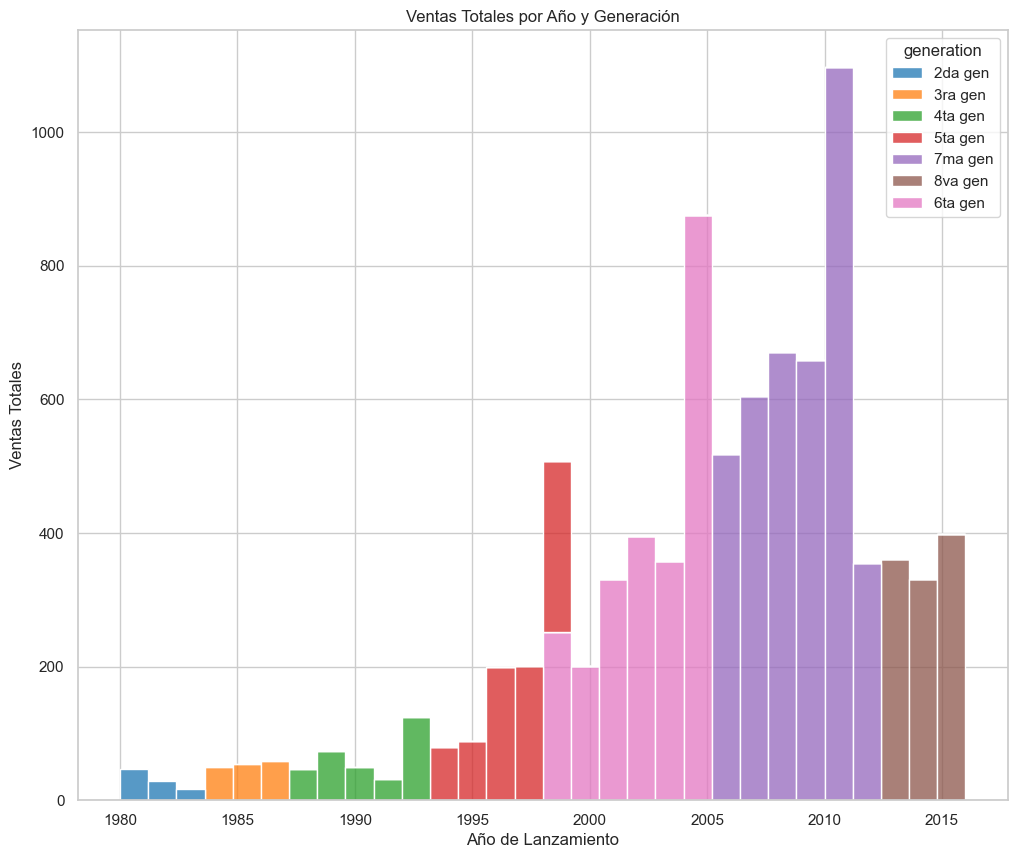

In [89]:
#Variación de ventas en plataformas nuevas y antiguas
generation_by_platform = {
             '1ra gen': [1972, 1976],
             '2da gen': [1977, 1983],
             '3ra gen': [1984, 1987],
             '4ta gen': [1988, 1993],
             '5ta gen': [1994, 1998],
             '6ta gen': [1999, 2005],
             '7ma gen': [2006, 2012],
             '8va gen': [2013, 2020]
}
sales_by_platform = games_df.groupby(['platform','year_of_release'])['total_sales'].sum().reset_index()
sales_by_platform.sort_values(by='year_of_release',ascending=True)

def get_generation(year):
    for generation, years in generation_by_platform.items():
        if years[0] <= year <= years[1]:
            return generation
    return 'Desconocida'

sales_by_platform['generation'] = sales_by_platform['year_of_release'].apply(get_generation)

# Graficar el histograma
plt.figure(figsize=(12, 10))

# Crea el histograma usando Seaborn
sns.histplot(
    data=sales_by_platform,
    x='year_of_release',
    weights='total_sales',
    hue='generation',
    multiple='stack',
    bins=30,
    palette='tab10'
)

# Añade título y etiquetas a los ejes
plt.title('Ventas Totales por Año y Generación')
plt.xlabel('Año de Lanzamiento')
plt.ylabel('Ventas Totales')

# Muestra el gráfico
plt.show()

In [90]:
def best_seller(df,top=10):
    
    #Clasificacion por total de ventas
    top_platforms = df.groupby('platform')['total_sales'].sum()
    top_platforms_sorted = top_platforms.sort_values(ascending=False)
    top_platforms_filtered = top_platforms_sorted.head(top)
    top_platforms_filtered = top_platforms_filtered.reset_index()
    
    pforms = pd.DataFrame()

    for pform in top_platforms_filtered['platform']:
        pform_data = df[df['platform'] == pform]
        pforms = pd.concat([pforms, pform_data])
    # Graficar el pairplot 
    fig = px.line(pforms, x='year_of_release', y='total_sales', color='platform', title='Distribución de Ventas por Año para las Principales Plataformas')
    fig.show()
    
    return pforms

# Assuming 'sales_by_platform' is your DataFrame
top_seller_df = best_seller(sales_by_platform)


In [101]:
# Calcular el primer y último año de ventas para cada plataforma
platform_years = top_seller_df.groupby('platform')['year_of_release'].agg(['min', 'max']).reset_index()

# Calcular el tiempo activo de cada plataforma
platform_years['active_years'] = platform_years['max'] - platform_years['min']

# Visualizar la duración de actividad de cada plataforma
fig = px.bar(platform_years, x='platform', y='active_years', title='Duración de Actividad de las Plataformas')
fig.show()

# Promedio del tiempo que tardan en aparecer y desaparecer
average_active_years = platform_years['active_years'].mean()
print(f'Podemos notar que el tiempo promedio de una plataforma con mayor venta es de: {average_active_years:.2f} años.')


Podemos notar que el tiempo promedio de una plataforma con mayor venta es de: 10.50 años.


Siguendo la tendencia de las plataformas con más ventas, podemos considerar lo siguiente:
1. PS2, Wii, y DS son plataformas con ventas totales muy altas y una gran variabilidad en las ventas de sus juegos.
2. X360 y PS3 también muestran una alta variabilidad en las ventas, pero con medianas ligeramente más bajas.
3. GBA, PSP, y 3DS tienen ventas más bajas y una distribución más homogénea.

Como caso extra, Wii se tiene como una de las plataformas en donde algunos de sus títulos tuvieron ventas extraordinarias que se destacan del resto.

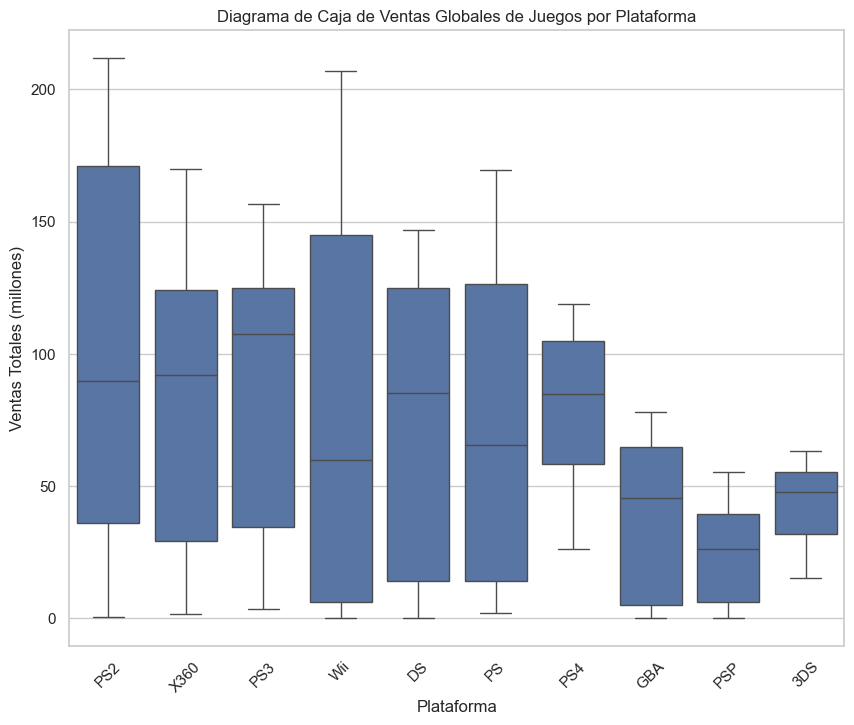

In [92]:
# Crear el diagrama de caja
plt.figure(figsize=(10, 8))
sns.set_theme(style="whitegrid")
sns.boxplot(x="platform", y="total_sales", data=top_seller_df)
plt.xticks(rotation=45)
plt.title("Diagrama de Caja de Ventas Globales de Juegos por Plataforma")
plt.xlabel("Plataforma")
plt.ylabel("Ventas Totales (millones)")
plt.show()

Muchas de los videojuegos de la plataforma PlayStation 2 (PS2), las reseñas de criticos tienen una correlación ligeramente mayor en relación a la de los usuarios. 
Aunque haya sido más grande, no significa que las tendencias de ventas puedan ser debido a las calificaciones más altas por parte del mismo

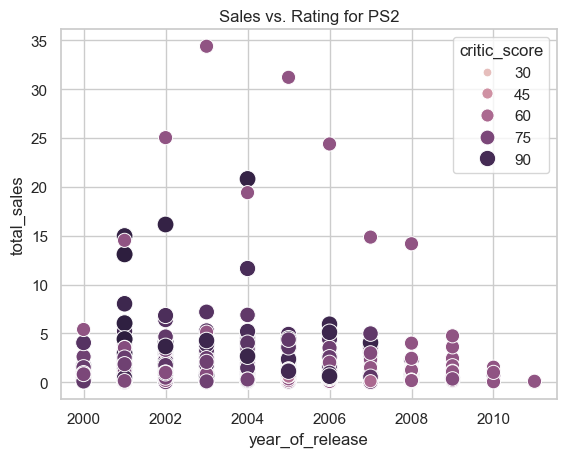

Correlación entre las reseñas de usuarios y las ventas: 0.10
Correlación entre las reseñas de críticos y las ventas: 0.24


In [93]:
def platform_review (df,pf='PS2'):
    pform_filtered = df[df['platform']==pf]
    rating_sales = pform_filtered.groupby(['rating','user_score','critic_score','year_of_release'])['total_sales'].sum()
    rating_sales = rating_sales.reset_index()
    sns.scatterplot(data=rating_sales,x='year_of_release', y="total_sales", hue="critic_score",size="critic_score",sizes=(30, 150))
    plt.title(f'Sales vs. Rating for {pf}')
    plt.show()
    return rating_sales

review_result = platform_review(games_df)

# Calcular la correlación entre las reseñas de usuarios y las ventas
user_score_corr = review_result['user_score'].corr(review_result['total_sales'])
print(f'Correlación entre las reseñas de usuarios y las ventas: {user_score_corr:.2f}')

# Calcular la correlación entre las reseñas de críticos y las ventas
critic_score_corr =review_result['critic_score'].corr(review_result['total_sales'])
print(f'Correlación entre las reseñas de críticos y las ventas: {critic_score_corr:.2f}')

   

In [94]:
correlation_matrix = review_result[['user_score', 'critic_score', 'total_sales']].corr()
correlation_matrix

,user_score,critic_score,total_sales
user_score,1.000000,0.530665,0.095003
critic_score,0.530665,1.000000,0.243969
total_sales,0.095003,0.243969,1.000000


In [95]:
sales_genre = games_df.groupby('genre')['total_sales'].sum().reset_index()
sales_sorted = sales_genre.sort_values(by='total_sales',ascending=False)

In [96]:
# Calcular estadísticas descriptivas
mean_sales = np.mean(sales_genre['total_sales'])
std_sales = np.std(sales_genre['total_sales'])

mean_sales, std_sales

(734.5308333333332, 452.4333011332229)

In [97]:
fig = px.bar(sales_sorted, x="genre", y="total_sales", 
             color="total_sales", 
             title="Sales by genre", 
             labels={'total_sales': 'Sales in millions'})
# Mostrar el gráfico
fig.show()

In [98]:
# Filtrar las filas relevantes
region_sales = games_df[games_df['platform'].notna() & games_df['genre'].notna() & games_df['rating'].notna()]

# Agrupar los datos por plataforma y sumar las ventas en cada región
platform_sales = games_df.groupby('platform').sum()[['na_sales', 'eu_sales', 'jp_sales', 'total_sales']]
platform_sales['total_sales'] = platform_sales['na_sales'] + platform_sales['eu_sales'] + platform_sales['jp_sales']

# Obtener las cinco principales plataformas por región
top5_platforms_na = platform_sales.sort_values(by='na_sales', ascending=False).head(5)
top5_platforms_eu = platform_sales.sort_values(by='eu_sales', ascending=False).head(5)
top5_platforms_jp = platform_sales.sort_values(by='jp_sales', ascending=False).head(5)

# Agrupar los datos por género y sumar las ventas en cada región
genre_sales = games_df.groupby('genre').sum()[['na_sales', 'eu_sales', 'jp_sales', 'total_sales']]
genre_sales['total_sales'] = genre_sales['na_sales'] + genre_sales['eu_sales'] + genre_sales['jp_sales']

# Obtener los cinco principales géneros por región
top5_genres_na = genre_sales.sort_values(by='na_sales', ascending=False).head(5)
top5_genres_eu = genre_sales.sort_values(by='eu_sales', ascending=False).head(5)
top5_genres_jp = genre_sales.sort_values(by='jp_sales', ascending=False).head(5)

# Agrupar los datos por clasificación de ESRB y sumar las ventas en cada región
rating_sales = games_df.groupby('rating').sum()[['na_sales', 'eu_sales', 'jp_sales', 'total_sales']]
rating_sales['total_sales'] = rating_sales['na_sales'] + rating_sales['eu_sales'] + rating_sales['jp_sales']

# Mostrar los resultados
(top5_platforms_na, top5_platforms_eu, top5_platforms_jp, top5_genres_na, top5_genres_eu, top5_genres_jp, rating_sales)

(          na_sales  eu_sales  jp_sales  total_sales
 platform                                           
 X360        595.74    268.32     12.30       876.36
 PS2         572.92    332.63    137.54      1043.09
 Wii         486.87    258.32     68.28       813.47
 PS3         390.13    327.21     79.41       796.75
 DS          380.31    188.41    175.02       743.74,
           na_sales  eu_sales  jp_sales  total_sales
 platform                                           
 PS2         572.92    332.63    137.54      1043.09
 PS3         390.13    327.21     79.41       796.75
 X360        595.74    268.32     12.30       876.36
 Wii         486.87    258.32     68.28       813.47
 PS          334.72    212.39    139.78       686.89,
           na_sales  eu_sales  jp_sales  total_sales
 platform                                           
 DS          380.31    188.41    175.02       743.74
 PS          334.72    212.39    139.78       686.89
 PS2         572.92    332.63    137.54     

In [99]:
# Filtrar datos para las plataformas Xbox One y PC
xbox_one_ratings = games_df[games_df['platform'] == 'XOne']['user_score'].dropna()
pc_ratings = games_df[games_df['platform'] == 'PC']['user_score'].dropna()

# Filtrar datos para los géneros Acción y Deportes
action_ratings = games_df[games_df['genre'] == 'Action']['user_score'].dropna()
sports_ratings = games_df[games_df['genre'] == 'Sports']['user_score'].dropna()

# Prueba t para las plataformas Xbox One y PC
t_stat_platforms, p_value_platforms = ttest_ind(xbox_one_ratings, pc_ratings, equal_var=False)

# Prueba t para los géneros Acción y Deportes
t_stat_genres, p_value_genres = ttest_ind(action_ratings, sports_ratings, equal_var=False)

(t_stat_platforms, p_value_platforms, t_stat_genres, p_value_genres)

(-4.478324274814948,
 9.70682510231706e-06,
 1.5276246657698103,
 0.12667199693364814)

Conclusiones:
- Las generaciones 6ta, 7ma, y 8va con mayor innovación y crecimiento de mayores generos y para todo tipo de edades en especifico a los adolecentes y maduros fueron las que mayor venta generaron.
- Las calificaciones no fueron relevantes entre las tendencias de ventas.
- Los generos de Action, Sports, Shooter, Role-Playing, Platform, y Misc son las plataformas con mayores ventas por encima de la media